In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/예선데이터/"

/content/drive/MyDrive/Colab Notebooks/예선데이터


In [3]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 707 kB 8.9 MB/s 
     |████████████████████████████████| 419 kB 59.8 MB/s 
     |████████████████████████████████| 5.9 MB 49.1 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [4]:
!nvidia-smi

Thu Sep 15 23:04:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# !pip freeze >requirements.txt

In [6]:
import os
import pickle
import datetime
import json
from typing import List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

import matplotlib.pyplot as plt
import pytorch_lightning as pl

# Dataset

In [34]:
pl.seed_everything(2036)

INFO:pytorch_lightning.utilities.seed:Global seed set to 2036


2036

In [35]:
!dir

answer_sample.csv
baseline.py
ConvLSTM
Data_processing.ipynb
Ensemble
lightning_logs
models
Model_training.ipynb
predictions
requirements.txt
test_input.csv
test_processed_input_2022-09-05\ 14:32:32.104316.csv
test_processed_input_2022-09-06\ 04:25:40.350178.csv
test_processed_input_2022-09-09\ 05:45:42.236002.csv
test_processed_input_2022-09-09\ 11:11:42.238441.csv
test_processed_input_2022-09-11\ 04:48:25.481555.csv
test_processed_input_2022-09-11\ 08:20:57.091760.csv
test_processed_input_2022-09-11\ 11:01:50.111313.csv
test_processed_input_2022-09-11\ 11:05:21.378887.csv
test_processed_input_2022-09-15\ 13:30:25.016877.csv
test_processed_input_2022-09-15\ 15:35:24.412296.csv
test_processed_input.csv
train_input.csv
train_output.csv
train_processed_input_2022-09-05\ 14:32:32.104316.csv
train_processed_input_2022-09-06\ 04:25:40.350178.csv
train_processed_input_2022-09-09\ 05:45:42.236002.csv
train_processed_input_2022-09-09\ 11:11:42.238441.csv
train_processed_input_2022-09-11\ 04:48

In [36]:
train_input_df = pd.read_csv("./train_processed_input_2022-09-15 15:35:24.412296.csv")
train_output_df = pd.read_csv("./train_processed_output.csv")
test_input_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/예선데이터/test_processed_input_2022-09-15 15:35:24.412296.csv")
answer_sample = pd.read_csv("./answer_sample.csv")

In [37]:
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10626 entries, 0 to 10625
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sample_no               10626 non-null  int64  
 1   Week                    10626 non-null  float64
 2   InCO2                   10626 non-null  float64
 3   InHumidity              10626 non-null  float64
 4   InTemp                  10626 non-null  float64
 5   SolarRadiation          10626 non-null  float64
 6   NutrientSupplyEC(ds/m)  10626 non-null  float64
 7   NutrientSupplypH        10626 non-null  float64
 8   Doy                     10626 non-null  float64
 9   TotalNutrientSupply     10626 non-null  float64
 10  CultivationForm_soil    10626 non-null  int64  
 11  CultivationForm_water   10626 non-null  int64  
 12  FarmID_farm01           10626 non-null  int64  
 13  FarmID_farm02           10626 non-null  int64  
 14  FarmID_farm03           10626 non-null

In [38]:
class CultureDataset(Dataset):
    def __init__(self, input_df:pd.DataFrame, output_df:pd.DataFrame = None, train_mode = True):
        self.input_df = input_df
        self.output_df = output_df
        self.train_mode = train_mode

        self.input_data = []
        self.label_data = []
        
        for key, value in self.input_df.groupby("Sample_no", as_index = False).groups.items():
            x = self.input_df.loc[value].drop("Sample_no", axis = 1).to_numpy()
            self.input_data.append(torch.tensor(x, dtype=torch.float32))
            
            if self.train_mode:
                y = np.squeeze(self.output_df[self.output_df["Sample_no"] == key].drop(["Sample_no", "Date", "Week"], axis = 1).to_numpy())
            else:
                y = np.zeros(3)

            self.label_data.append(torch.tensor(y, dtype=torch.float32))


    def __getitem__(self, idx):
        x = self.input_data[idx]
        y = self.label_data[idx]

        return x, y

    def __len__(self):
        return len(self.input_data)

In [39]:
batch_size = 16
epochs = 400 
input_size = train_input_df.shape[1] - 1
train_test_split_ratio = 0.95 # best 1.0
ensemble_size = 5

In [40]:
culturedataset = CultureDataset(train_input_df, train_output_df)
test_dataset = CultureDataset(test_input_df, train_mode = False)

In [41]:
dataset_length = len(culturedataset)

train_len = int(dataset_length * train_test_split_ratio)
val_len = dataset_length - train_len

train_dataset, val_dataset = random_split(culturedataset, [train_len, val_len])

In [42]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [43]:
total_dataloader = DataLoader(culturedataset, batch_size = batch_size, shuffle = True)
total_val_dataloader = DataLoader(culturedataset, batch_size = batch_size, shuffle = False)

In [44]:
def predict(model:nn.Module, trainer:pl.Trainer, df:pd.DataFrame, dataloader)->pd.DataFrame:
    print(f"Best epoch : {model.best_epoch}, Best score : {model.best_score}")
    model.load_state_dict(model.best_model)

    predictions = trainer.predict(model, dataloaders = dataloader)

    results = np.concatenate([pred.detach().numpy() for pred in predictions])
    df[["생장길이", "줄기직경", "개화군"]] = results

    return df

# Model 정의

In [45]:
class BaseSequenceModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, learning_rate, dropout, train_dataloader, val_dataloader, early_stopping, model_id = None):
        super().__init__()
        self.loss = self.custom_loss
        self.train_record = []
        self.val_record = []
        self.lr_record = []
        self.train_loss = 0
        self.val_loss = 0
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.best_model = None
        self.best_epoch = None
        self.best_score = None
        self.optimizer = None
        self.lr_scheduler = None
        self.name = self.__class__.__name__ + str(model_id) if model_id else self.__class__.__name__
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.early_stopping = early_stopping

    def forward(self, x):
        raise NotImplementedError

    def configure_optimizers(self):
        raise NotImplementedError

    def custom_loss(self, out, tgt):
        growth_mae = self.mae(out[:, 0], tgt[:,0])
        stem_mae = self.mae(out[:, 1], tgt[:, 1])
        flowering_mae = self.mae(out[:, 2], tgt[:, 2])

        return (growth_mae*0.1 + stem_mae + flowering_mae)/3

    def mae(self, true, pred):
        return torch.mean(torch.abs(true - pred))

    def training_step(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.train_loss += loss
        
        return loss

    def on_train_epoch_end(self) -> None:
        self.train_record.append(self.train_loss.cpu().detach().numpy() / len(self.train_dataloader))
        self.train_loss = 0

        self.val_record.append(self.val_loss.cpu().detach().numpy() / len(self.val_dataloader))
        self.val_loss = 0
        self.lr_record.append(self.lr_scheduler.get_last_lr())  

        # early-stopping
        if self.early_stopping:
            if min(self.val_record) == self.val_record[-1]:
                self.best_model = self.state_dict()
                self.best_epoch = len(self.val_record) - 1
                self.best_score = self.val_record[-1]
        else:
            self.best_model = self.state_dict()
            self.best_epoch = len(self.val_record) - 1
            self.best_score = self.val_record[-1]

        self.log("loss", {f"{self.name}_train_loss" : self.train_record[-1], f"{self.name}_val_loss" : self.val_record[-1]})
        return


    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.val_loss += loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self(x)
        return y_hat

In [62]:
class ConvLSTMSequenceModel(BaseSequenceModel):
    def __init__(self, input_size, hidden_size, num_layers, learning_rate, dropout, train_dataloader, val_dataloader, early_stopping = True, model_id = None):
        super().__init__(input_size, hidden_size, num_layers, learning_rate, dropout, train_dataloader, val_dataloader, early_stopping, model_id)

        self.conv1 = nn.Sequential(
            nn.Conv1d(self.input_size, 64, 3, stride = 1, padding = 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, 3, stride = 1, padding = 1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, 3, stride = 1, padding = 1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.lstm = nn.Sequential(
            nn.LSTM(input_size = 256, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = True)
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)           
        )

    def forward(self, x):
        # convolution layer 1
        x = x.reshape(-1, self.input_size, 7)
        x = self.conv1(x)

        # convolution layer 2
        x = self.conv2(x)

        # convolution layer 3
        x = self.conv3(x)

        # lstm layer
        x = x.reshape(-1, 7, 256)
        x, _ = self.lstm(x)

        # fully connected layer
        x = x[:, -1, :].reshape(-1, self.hidden_size)
        x = self.fc(x)

        return x
    
    def configure_optimizers(self):
        self.optimizer = Adam(self.parameters(), lr = self.learning_rate)
        self.lr_scheduler = OneCycleLR(self.optimizer, max_lr = self.learning_rate, total_steps = epochs, pct_start = 90/epochs, final_div_factor = 5000)

        return [self.optimizer], [self.lr_scheduler]

# Train

In [63]:
learning_rate = 1e-4
hidden_size = 1024
num_layers = 2
dropout = 0.2 # 0.2

In [64]:
total_convlstm_model = ConvLSTMSequenceModel(input_size, 
                                             hidden_size, 
                                             num_layers,
                                             learning_rate, 
                                             dropout, 
                                             train_dataloader = total_dataloader, 
                                             val_dataloader = val_dataloader, 
                                             early_stopping = False)

total_convlstm_trainer = pl.Trainer(max_epochs = epochs, accelerator='gpu', devices=1)
# total_convlstm_trainer = pl.Trainer(max_epochs = epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [66]:
print(total_convlstm_model)

ConvLSTMSequenceModel(
  (conv1): Sequential(
    (0): Conv1d(55, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (lstm): Sequential(
    (0): LSTM(256, 1024, num_layers=2, batch_first=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256

In [67]:
total_convlstm_trainer.fit(total_convlstm_model, train_dataloaders=total_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 10.8 K
1 | conv2 | Sequential | 25.0 K
2 | conv3 | Sequential | 99.1 K
3 | lstm  | Sequential | 13.6 M
4 | fc    | Sequential | 689 K 
-------------------------------------
14.5 M    Trainable params
0         Non-trainable params
14.5 M    Total params
57.888    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:289: UserWarning: The ``compute`` method of metric _ResultMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  f"The ``compute`` method of metric {self.__class__.__name__}"


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


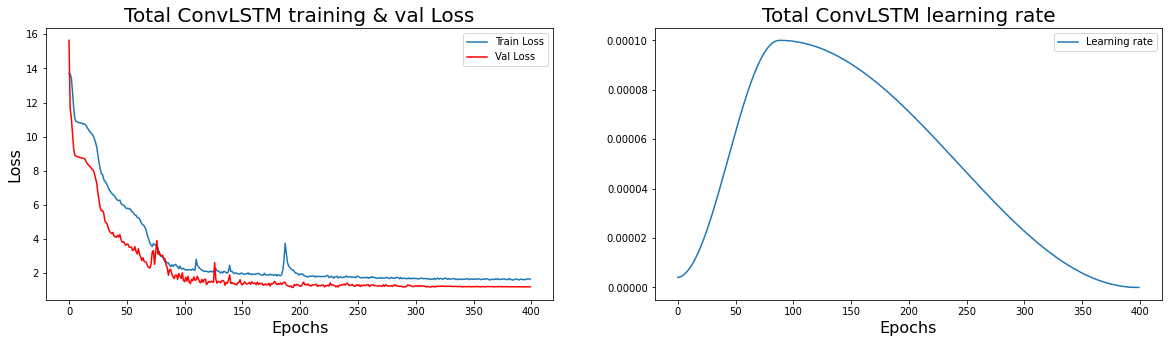

In [68]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.plot(total_convlstm_model.train_record, label="Train Loss") 
plt.plot(total_convlstm_model.val_record, 'r', label="Val Loss") 
plt.title('Total ConvLSTM training & val Loss', fontsize=20) 
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(total_convlstm_model.lr_record, label="Learning rate")  
plt.title('Total ConvLSTM learning rate', fontsize=20) 
plt.xlabel('Epochs',fontsize=16)
plt.legend()
plt.show()

In [69]:
total_convlstm_test_result = predict(total_convlstm_model, total_convlstm_trainer, answer_sample, test_dataloader)

Best epoch : 399, Best score : 1.2063844680786133


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 95it [00:00, ?it/s]

In [70]:
print(total_convlstm_model.train_record[-5:])

[1.621544607062089, 1.6646135832134046, 1.6687051873458059, 1.6728255422491776, 1.6454744037828948]


# Predict

In [71]:
ctime = str(datetime.datetime.now())

print(ctime)
torch.save(total_convlstm_model, f"./models/total_convlstm_{ctime}.pt")
total_convlstm_test_result.to_csv(f"./predictions/total_convlstm_{ctime}.csv", index = False, encoding='utf-8')

2022-09-16 00:13:05.007475
